# Figure 5 inspection

here we would like to do the cost breakdown for a few different models:
- the nominal model
- the model with low time-cost
- model with low time-cost



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2428
Number of nonzeros in inequality constraint Jacobian.:     1072
Number of nonzeros in Lagrangian Hessian.............:      817

Total number of variables............................:      919
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

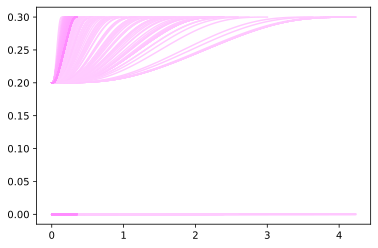

In [1]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
import colour as clr
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.PointMass()

# starting x and y
x = 0.0
ys = 0.20
xystart = np.array([x,ys])

loopValuation = [50, 1, .25]
loopdist = np.array([.1])

color1 = clr.Color("#e0f3db")
distcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))

### storing the main results: durations, speeds, costs.
M = len(loopValuation)
N = len(loopdist)
duration      = np.zeros([M, N])
J             = np.zeros([M, N])
costFR        = np.zeros([M, N])
costWork      = np.zeros([M, N])
costTime      = np.zeros([M, N])
peakhandspeed = np.zeros([M, N])
solved        = np.zeros([M, N])
distances     = np.zeros([M, N])
nDist         = 0 #counters
mVal          = 0 #counters

### store returned trajectories
# store trajectories
trajAll       = list() #ultimately the 2D matrix storage
trajFixedDist = list() # fixedDist get reset each inner loop
# store returned Opti variables
optiAll       = list() # ultimately the 2D matrix storage 
optiFixedDist = list() # fixedDist get reset each inner loop

### setup the optimization. 
optiPrev = sim.movementTimeOptSetup(
  theTimeValuation  = 1.0,
  theN              = 50,
  theFRCoef         = 0.085)

### solve the opt once, we can then always use optiOrig as initial guess. 


trajOrig, optiOrig = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]), 
  theDurationInitial  = 0.5,
  theTimeValuation    = 1,
  theGeneratePlots    = 0,
  theFRCoef=8.5e-2)
dGuess = trajOrig.duration

trajHighTime, optiHighTime = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([x,.1]), 
      theDurationInitial  = dGuess,
      theTimeValuation    = 30,
      theFRCoef=8.5e-2,
      theGeneratePlots    = 0)

trajLowTime, optiLowTime = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([x,.1]), 
      theDurationInitial  = dGuess,
      theTimeValuation    = .1,
      theFRCoef=8.5e-2,
      theGeneratePlots    = 0)

trajHighFR, optiHighFR = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]), 
  theDurationInitial  = 0.5,
  theTimeValuation    = 1,
  theGeneratePlots    = 0,
  theFRCoef=8.5)

trajLowFR, optiLowFR = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]), 
  theDurationInitial  = 0.5,
  theTimeValuation    = 1,
  theGeneratePlots    = 0,
  theFRCoef=8.5e-5)

#%% now plot each


# Inspection
Plot incremental (s^-1) cost for different movements. 

Makes intuitive sense to plot the three costs
- energy
- force rate
- time
- 


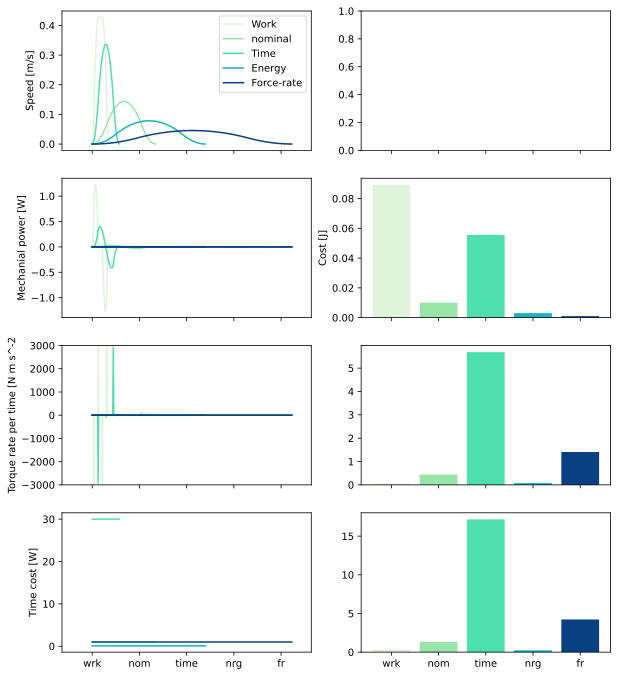

In [10]:
listOptis = [optiLowFR, optiOrig, optiHighTime, optiLowTime, optiHighFR]
listTraj = [trajLowFR,  trajOrig, trajHighTime, trajLowTime, trajHighFR]
labels = ["Work", "nominal", "Time","Energy","Force-rate"]
color1 = clr.Color("#e0f3db")
colors = list(color1.range_to(clr.Color("#084081"),len(listTraj)))
ic = 0
cmPerIn = 2.54
widthCM = 25 #cm
heightCM = 30 #cm
fig, axs = plt.subplots(4, 2, sharex=True, figsize = (widthCM/cmPerIn,heightCM/cmPerIn))
for itraj in listTraj:
  axs[0, 0].plot(itraj.time, itraj.handspeed, color = colors[ic].get_hex(),label = labels[ic])
  axs[0, 0].set_ylabel("Speed [m/s]")
  axs[1, 0].plot(itraj.time, itraj.mechPower.T,color = colors[ic].get_hex(),label = labels[ic])
  axs[1, 0].set_ylabel("Mechanial power [W]")
  axs[2, 0].plot(itraj.time, itraj.uraterate.T,color = colors[ic].get_hex(),label = labels[ic])
  axs[2, 0].set_ylabel("Torque rate per time [N m s^-2")
  axs[2, 0].set_ylim([-3000,3000])
  nT = np.shape(itraj.time)[0]
  axs[3, 0].plot(itraj.time, np.ones(nT)*itraj.costTime/itraj.time[-1],color = colors[ic].get_hex(),label = labels[ic])
  axs[3, 0].set_ylabel("Time cost [W]")

  axs[1, 1].bar(ic, itraj.costWork, color = colors[ic].get_hex())
  axs[1, 1].set_ylabel("Cost [J]")
  axs[1,1].xaxis.set_ticks([0,1,2,3,4])
  axs[1,1].set_xticklabels(["wrk","nom","time","nrg","fr"])
  axs[2, 1].bar(ic, itraj.costFR, color = colors[ic].get_hex())
  axs[1, 1].set_ylabel("Cost [J]")
  axs[1,1].xaxis.set_ticks([0,1,2,3,4])
  axs[1,1].set_xticklabels(["wrk","nom","time","nrg","fr"])
  axs[3, 1].bar(ic, itraj.costTime, color = colors[ic].get_hex())
  axs[1, 1].set_ylabel("Cost [J]")
  axs[1,1].xaxis.set_ticks([0,1,2,3,4])
  axs[1,1].set_xticklabels(["wrk","nom","time","nrg","fr"])
  
  ic+=1
axs[0,0].legend(loc='upper right')
plt.show()


In [53]:
# sanity check on mechanical work.
peakeK = 1/2*sim.m[0]*.4*.4
peakeK

0.08000000000000002